这里主要是学习Scipy的Optimization库的笔记，该教程链接在[这里](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)

scipy.optimize包提供了一些常见的最优化算法，可在[这里](https://docs.scipy.org/doc/scipy/reference/optimize.html#module-scipy.optimize)查看。该模块主要包括了一下几个内容：

- minimize使用各种算法对非限定或限定的multivariate scalar functions进行最小值求解
- 全局最优化路线
- 最小二次乘法最优化求解和curve fitting算法
- Scalar univariate functions最小化及根求解
- 使用大量算法求解多元方程组等

下面记录一些简单常用的最优化算法及其应用：

### minimize function
#### The problem of minimizing the Rosenbrock function
下面的例子展示了怎样去定义一个对象函数以及它的jacobian和hessian函数

- Nelder-Mead Simplex algorithm (method='Nelder-Mead')

首先选取的最优化算法是Nelder-Mead Simplex算法

In [15]:
import numpy as np
from scipy.optimize import minimize

In [16]:
def rosen(x):
    '''The Rosenbrock function'''
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

In [17]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(rosen, x0, method='nelder-mead',options={'xtol':1e-8,'disp':True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 339
         Function evaluations: 571


In [18]:
print(res)

 final_simplex: (array([[ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ,  1.00000001,  1.00000001],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  0.99999999]]), array([  4.86115343e-17,   7.65182843e-17,   8.11395684e-17,
         8.63263255e-17,   8.64080682e-17,   2.17927418e-16]))
           fun: 4.8611534334221152e-17
       message: 'Optimization terminated successfully.'
          nfev: 571
           nit: 339
        status: 0
       success: True
             x: array([ 1.,  1.,  1.,  1.,  1.])


In [19]:
print(res.x) # the solutuion of the optimization


[ 1.  1.  1.  1.  1.]


这是最优化求解一个函数的最简单的方法，适合简单的情况。不过由于它没有提供任何梯度优化，所以会花费一些时间来寻找最小值；另一个相似算法是```Powells```。

- Broyden-Fletcher-Goldfarb-Shanno algorithm (method='BFGS')

为了更快得收敛到结果，这个方法用了梯度函数。

In [22]:
#定义梯度函数,注意向量的平方如何表示
def rosen_der(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

In [23]:
# 在monimize方法中使用jac跳用梯度函数
res = minimize(rosen, x0, method='BFGS', jac=rosen_der,
               options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30


In [24]:
res.x

array([ 1.00000004,  1.0000001 ,  1.00000021,  1.00000044,  1.00000092])

- Newton-Conjugate-Gradient algorithm (method='Newton-CG')
Newton-CG梯度算法是Newton方法的改造，Newton方法是基于一个二次型的局部拟合。这里引入了Hsssian

为了能够更好的发挥这个算法，最好提供计算Hessian的函数：

In [25]:
def rosen_hess(x):
    x = np.asarray(x)
    H = np.diag(-400*x[:-1],1) - np.diag(400*x[:-1],-1)
    diagonal = np.zeros_like(x)
    diagonal[0] = 1200*x[0]**2-400*x[1]+2
    diagonal[-1] = 200
    diagonal[1:-1] = 202 + 1200*x[1:-1]**2 - 400*x[2:]
    H = H + np.diag(diagonal)
    return H

In [27]:
res = minimize(rosen, x0, method='Newton-CG',
               jac=rosen_der, hess=rosen_hess,
               options={'xtol': 1e-8, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 56
         Hessian evaluations: 24
[ 1.          1.          1.          0.99999999  0.99999999]


#### 带限制的多元函数最优化

- Trust-Region Constrained Algorithm 

该算法可解决某种形式的限制最优化问题，具体可见[url](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)

    + 定义边界
    + 定义线性限制
    + 定义非线性条件
    + 求解最优化问题

#### 最小二次乘法最优化
该算法都会使用一个偏导数叫做jacobian

In [36]:
from scipy.optimize import least_squares
# 定义model
def model(x, u):
    return x[0] * (u ** 2 + x[1] * u) / (u ** 2 + x[2] * u + x[3])
#定义函数
def fun(x, u, y):
    return model(x, u) - y
# 定义偏导数 Jacobial
def jac(x, u, y):
    J = np.empty((u.size, x.size))
    den = u ** 2 + x[2] * u + x[3]
    num = u ** 2 + x[1] * u
    J[:, 0] = num / den
    J[:, 1] = x[0] * u / den
    J[:, 2] = -x[0] * num * u / den ** 2
    J[:, 3] = -x[0] * num / den ** 2
    return J

In [37]:
# 初始化数据
u = np.array([4.0, 2.0, 1.0, 5.0e-1, 2.5e-1, 1.67e-1, 1.25e-1, 1.0e-1,
              8.33e-2, 7.14e-2, 6.25e-2])
y = np.array([1.957e-1, 1.947e-1, 1.735e-1, 1.6e-1, 8.44e-2, 6.27e-2,
              4.56e-2, 3.42e-2, 3.23e-2, 2.35e-2, 2.46e-2])
x0 = np.array([2.5, 3.9, 4.15, 3.9])

In [38]:
# 调用最小二次乘法算法
res = least_squares(fun, x0, jac=jac, bounds=(0, 100), 
                    args=(u, y), verbose=1)


`ftol` termination condition is satisfied.
Function evaluations 130, initial cost 4.4383e+00, final cost 1.5375e-04, first-order optimality 4.92e-08.


In [39]:
res.x # 输出最有解

array([ 0.19280596,  0.19130423,  0.12306063,  0.13607247])

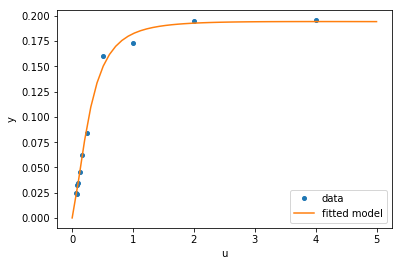

In [40]:
# 画出收敛过程图像
import matplotlib.pyplot as plt
u_test = np.linspace(0, 5)
y_test = model(res.x, u_test)
plt.plot(u, y, 'o', markersize=4, label='data')
plt.plot(u_test, y_test, label='fitted model')
plt.xlabel("u")
plt.ylabel("y")
plt.legend(loc='lower right')
plt.show()

### 最优化库的分类
- 局部最优化
- 等式（局部）最小化
- 全局最优化
- 拟合
- 求根
- 线性计算

更多还是得看[文档](https://docs.scipy.org/doc/scipy/reference/optimize.html#module-scipy.optimize)啊